In [1]:
import numpy as np
import pandas as pd
import pickle
from skimage.io import imread, imsave
from skimage import img_as_ubyte
from matplotlib import pyplot as plt
from collections import Counter

from platform import python_version

%matplotlib inline

np.__version__, python_version()

('1.18.5', '3.8.3')

### Allowed imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.ndimage import gaussian_filter
from skimage.metrics import peak_signal_noise_ratio

### PCA

In [3]:
def pca_compression(matrix, p):
    """ Сжатие изображения с помощью PCA
    Вход: двумерная матрица (одна цветовая компонента картинки), количество компонент
    Выход: собственные векторы, проекция матрицы на новое пр-во и средние значения до центрирования
    """
    # Отцентруем каждую строчку матрицы
    rows_centers = np.mean(matrix, axis=1)
    matrix_centered = matrix - rows_centers[:, None]
    # Найдем матрицу ковариации
    covariance = np.cov(matrix_centered, ddof=0)
    # Ищем собственные значения и собственные векторы матрицы ковариации, используйте linalg.eigh из numpy
    eig_val, eig_vec = np.linalg.eigh(covariance)
    # Посчитаем количество найденных собственных векторов
    n_eig_vec = eig_vec.shape[1]
    # Сортируем собственные значения в порядке убывания
    eig_val_sorted_indices = np.argsort(eig_val)[::-1]
    # Сортируем собственные векторы согласно отсортированным собственным значениям
    # !Это все для того, чтобы мы производили проекцию в направлении максимальной дисперсии!
    eig_vec_sorted = eig_vec[:, eig_val_sorted_indices]
    # Оставляем только p собственных векторов
    eig_vec_p = eig_vec_sorted[:, :p]
    # Проекция данных на новое пространство
    projection = eig_vec_p.T @ matrix_centered
    
    return eig_vec_p, projection, rows_centers

In [4]:
block_1 = np.array([
    [216, 202, 198, 183, 188, 205, 201, 188, 201, 229],
    [225, 210, 204, 199, 191, 193, 200, 204, 217, 239],
    [229, 203, 194, 202, 218, 233, 229, 215, 205, 204],
    [231, 221, 187, 213, 227, 218, 213, 225, 230, 222],
    [238, 237, 206, 192, 197, 223, 237, 233, 231, 239],
    [231, 230, 214, 210, 204, 208, 224, 240, 233, 218],
    [234, 235, 241, 245, 240, 228, 223, 227, 232, 230],
    [243, 239, 221, 212, 216, 230, 225, 204, 201, 213],
    [232, 219, 210, 226, 230, 225, 231, 241, 229, 206],
    [228, 212, 226, 223, 221, 220, 213, 207, 216, 229]
]).astype(np.float64)

eig_vec, projection, rows_centers = pca_compression(block_1, 3)
eig_vec, projection, rows_centers

(array([[-0.41494256,  0.31503407,  0.24019408],
        [-0.43327886,  0.40467947, -0.1883713 ],
        [-0.14110976, -0.49419626,  0.4443447 ],
        [-0.23292407, -0.31990887, -0.14200865],
        [-0.6501606 , -0.12963166, -0.06284166],
        [-0.29803484, -0.17964447, -0.38560341],
        [ 0.17314577,  0.15531999,  0.00495593],
        [-0.15530258, -0.02299255,  0.69590005],
        [ 0.01606426, -0.5001633 , -0.12694204],
        [ 0.0060443 ,  0.25792177,  0.19015676]]),
 array([[-34.29216421, -14.54868348,  27.598065  ,  41.42728306,
          34.40274329,   4.02716643,  -9.52290219,  -4.77091752,
         -10.9714896 , -33.34910079],
        [ -5.71745446,   2.78200885,  30.76951704,   6.33466383,
         -10.66882438, -13.06949226, -18.07776702, -25.27547585,
          -1.89117375,  34.813998  ],
        [ 17.43037105,   3.03788687,   3.4624839 ,  -5.7586607 ,
           5.94082531,  24.54201647,   8.54883811, -26.174826  ,
         -26.65791819,  -4.37101681]]),
 a

In [5]:
def pca_decompression(compressed):
    """ Разжатие изображения
    Вход: список кортежей из собственных векторов и проекций для каждой цветовой компоненты
    Выход: разжатое изображение
    """
    result_img = []
    for i, comp in enumerate(compressed):
        # Матрично умножаем собственные векторы на проекции и прибавляем среднее значение по строкам исходной матрицы
        # !Это следует из описанного в самом начале примера!
        eig_vec, projection, rows_centers = comp
        decompressed = eig_vec @ projection + rows_centers[:, None]
        decompressed = np.clip(decompressed, 0, 255).astype(np.uint8)
        result_img.append(decompressed)
    return np.dstack(result_img)

In [6]:
block_1 = np.array([
    [216, 202, 198, 183, 188, 205, 201, 188, 201, 229],
    [225, 210, 204, 199, 191, 193, 200, 204, 217, 239],
    [229, 203, 194, 202, 218, 233, 229, 215, 205, 204],
    [231, 221, 187, 213, 227, 218, 213, 225, 230, 222],
    [238, 237, 206, 192, 197, 223, 237, 233, 231, 239],
    [231, 230, 214, 210, 204, 208, 224, 240, 233, 218],
    [234, 235, 241, 245, 240, 228, 223, 227, 232, 230],
    [243, 239, 221, 212, 216, 230, 225, 204, 201, 213],
    [232, 219, 210, 226, 230, 225, 231, 241, 229, 206],
    [228, 212, 226, 223, 221, 220, 213, 207, 216, 229]
]).astype(np.float64)

answer = pca_decompression([pca_compression(block_1, 3), 
                            pca_compression(block_1, 4), 
                            pca_compression(block_1, 5)])
answer[:2]

array([[[217, 219, 215],
        [208, 205, 202],
        [200, 196, 197],
        [184, 185, 184],
        [184, 188, 187],
        [201, 201, 204],
        [201, 199, 201],
        [188, 187, 188],
        [198, 199, 200],
        [224, 227, 229]],

       [[217, 219, 222],
        [215, 210, 213],
        [208, 203, 202],
        [193, 195, 196],
        [187, 192, 192],
        [196, 197, 195],
        [203, 200, 198],
        [204, 203, 202],
        [217, 218, 218],
        [237, 240, 239]]], dtype=uint8)

<Figure size 432x288 with 0 Axes>

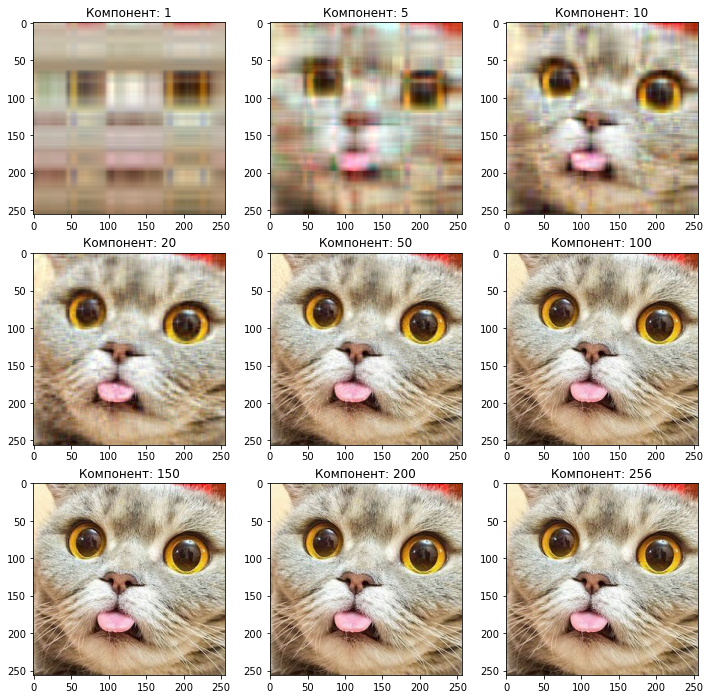

In [7]:
from image_compression import pca_visualize

pca_visualize()

### JPEG

In [8]:
lenna = imread('Lenna.png')[..., :3]

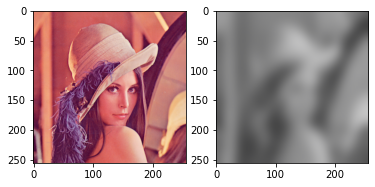

In [9]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(lenna)
axes[1].imshow(gaussian_filter(input=lenna, sigma=10))

In [10]:
def get_gauss_1():
    plt.clf()
    rgb_img = imread('Lenna.png')
    if len(rgb_img.shape) == 3:
        rgb_img = rgb_img[..., :3]
        
    YCbCr = rgb2ycbcr(rgb_img)
    Y, C_b, C_r = YCbCr[..., 0], YCbCr[..., 1], YCbCr[..., 2]
    C_b_blurred = gaussian_filter(input=C_b, sigma=10)
    C_r_blurred = gaussian_filter(input=C_r, sigma=10)
    restored = np.clip(ycbcr2rgb(np.dstack((Y, C_b_blurred, C_r_blurred))), 0, 255).astype(np.uint8)
    
    plt.imshow(restored)
    plt.savefig("gauss_1.png")

def get_gauss_2():
    plt.clf()
    rgb_img = imread('Lenna.png')
    if len(rgb_img.shape) == 3:
        rgb_img = rgb_img[..., :3]
        
    YCbCr = rgb2ycbcr(rgb_img)
    Y, C_b, C_r = YCbCr[..., 0], YCbCr[..., 1], YCbCr[..., 2]
    Y_blurred = gaussian_filter(input=Y, sigma=10)
    restored = np.clip(ycbcr2rgb(np.dstack((Y_blurred, C_b, C_r))), 0, 255).astype(np.uint8)
    
    plt.imshow(restored)
    plt.savefig("gauss_2.png")

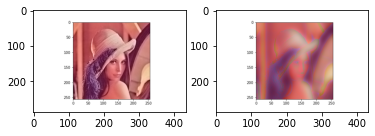

In [11]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(imread('gauss_1.png'))
axes[1].imshow(imread('gauss_2.png'))

In [12]:
def zigzag(block):
    res = []
    size = block.shape[0]
    block = np.flip(block, axis=0)
    for step, offset in enumerate(range(1-size, size)):
        res.append(np.diagonal(block, offset)[::(-1)**step])
    return np.concatenate(res)

In [13]:
m = np.array([
    [16, 11, 10, 16],
    [12, 12, 14, 19],
    [14, 13, 16, 24],
    [14, 17, 22, 29]]
)
z = zigzag(m)
z

array([16, 11, 12, 14, 12, 10, 16, 14, 13, 14, 17, 16, 19, 24, 22, 29])

In [14]:
def nth_matrix_diag(matrix, n):
    xx, yy = np.diag_indices_from(matrix)
    if n > 0:
        return xx[:-n], yy[n:]
    elif n < 0:
        return xx[-n:], yy[:n]
    else:
        return xx, yy

def inverse_zigzag(array):
    size = int(np.sqrt(len(array)))
    matrix = np.zeros((size, size))
    i = j = 0
    for step, offset in enumerate(range(1-size, size)):
        indices = nth_matrix_diag(matrix, offset)
        delta = len(indices[0])
        matrix[indices] = array[i:j+delta][::(-1)**step]
        i = j = j + delta
    matrix = np.flip(matrix, axis=0)
    return matrix

In [15]:
inverse_zigzag(z)

array([[16., 11., 10., 16.],
       [12., 12., 14., 19.],
       [14., 13., 16., 24.],
       [14., 17., 22., 29.]])

## Testing

In [16]:
from image_compression import jpeg_visualize, get_pca_metrics_graph, get_jpeg_metrics_graph

CPU times: user 3min 6s, sys: 415 ms, total: 3min 7s
Wall time: 3min 7s


<Figure size 432x288 with 0 Axes>

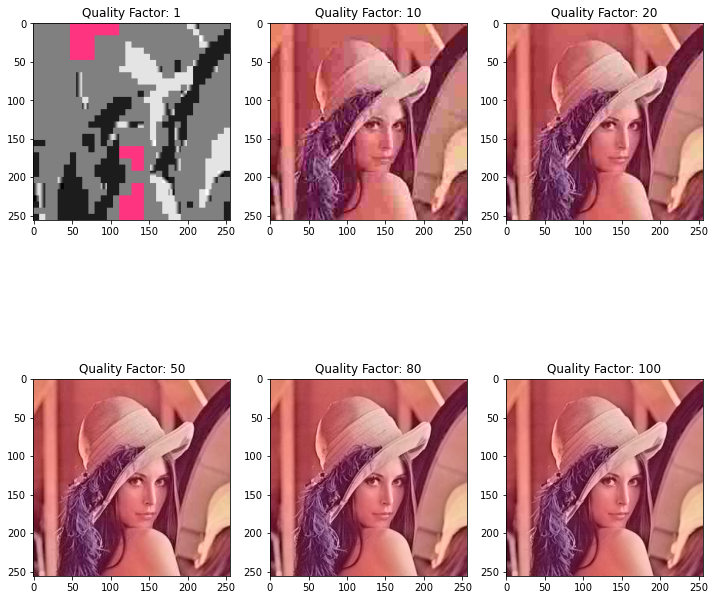

In [17]:
%%time
jpeg_visualize()

CPU times: user 3.67 s, sys: 800 ms, total: 4.47 s
Wall time: 615 ms


<Figure size 432x288 with 0 Axes>

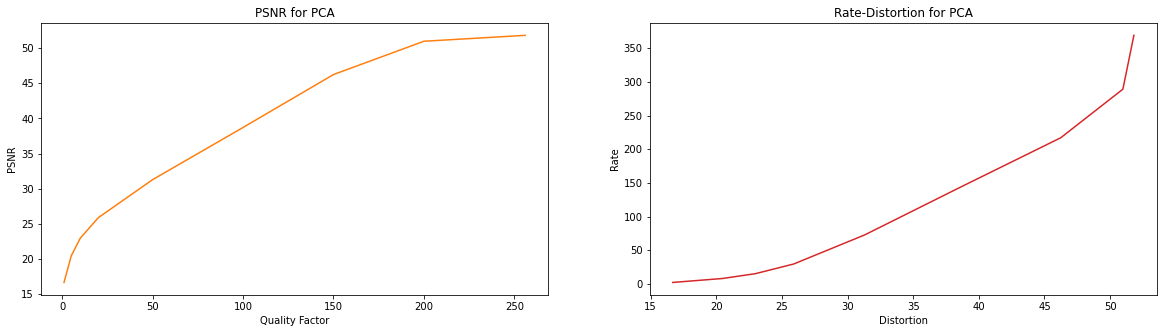

In [18]:
%%time
get_pca_metrics_graph()

CPU times: user 3min 6s, sys: 304 ms, total: 3min 6s
Wall time: 3min 6s


<Figure size 432x288 with 0 Axes>

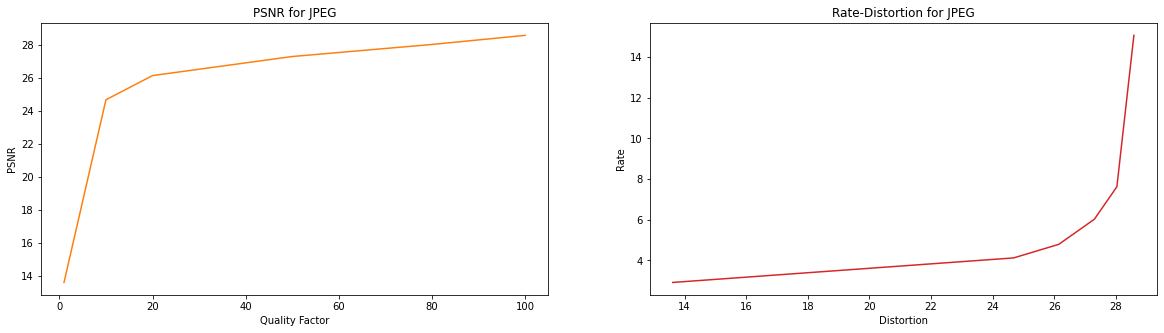

In [19]:
%%time
get_jpeg_metrics_graph()